
# Customer Churn Analysis 


In [3]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

sns.set_style('whitegrid')


In [4]:

# Load dataset (ensure file is present at this path)
csv_path = r"D:\Data Analysis Projects\customer_chrun\customer_churn_dataset.csv"
df = pd.read_csv("customer_churn_dataset.csv")
print("Loaded:", csv_path)
display(df.head())


Loaded: D:\Data Analysis Projects\customer_chrun\customer_churn_dataset.csv


,CustomerID,Gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaymentMethod,TechSupport,MonthlyCharges,TotalCharges,Churn
0,C00001,Male,0,No,No,9,Fiber optic,One year,Electronic check,No,124.62,1117.50,Yes
1,C00002,Female,0,Yes,No,2,DSL,Month-to-month,Electronic check,No,52.85,141.55,Yes
2,C00003,Female,0,Yes,No,63,DSL,Two year,Electronic check,Yes,46.44,2969.80,No
3,C00004,Female,0,No,No,5,Fiber optic,Month-to-month,Electronic check,No,62.97,313.81,No
4,C00005,Male,0,Yes,No,20,Fiber optic,One year,Electronic check,No,77.07,1507.18,No


In [5]:

# Basic info and quick cleaning
print('Shape:', df.shape)
print('\nColumns:', list(df.columns))
print('\nDatatype summary:')
display(df.dtypes.value_counts())

# Common cleaning steps: trim spaces, replace blanks with NaN
df = df.copy()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Replace common missing value markers
df.replace({'': np.nan, ' ': np.nan, 'NA': np.nan, 'N/A': np.nan}, inplace=True)

print('\nMissing values per column:')
display(df.isnull().sum())


Shape: (10000, 13)

Columns: ['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'InternetService', 'Contract', 'PaymentMethod', 'TechSupport', 'MonthlyCharges', 'TotalCharges', 'Churn']

Datatype summary:


object     9
int64      2
float64    2
Name: count, dtype: int64


Missing values per column:


CustomerID         0
Gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
InternetService    0
Contract           0
PaymentMethod      0
TechSupport        0
MonthlyCharges     0
TotalCharges       0
Churn              0
dtype: int64

In [6]:

# Convert numeric-like columns if necessary (example: 'MonthlyCharges', 'TotalCharges')
for col in ['MonthlyCharges', 'TotalCharges']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# If there is a 'Churn' column ensure it's 0/1
if 'Churn' in df.columns:
    print("\nChurn unique values:", df['Churn'].unique())



Churn unique values: ['Yes' 'No']


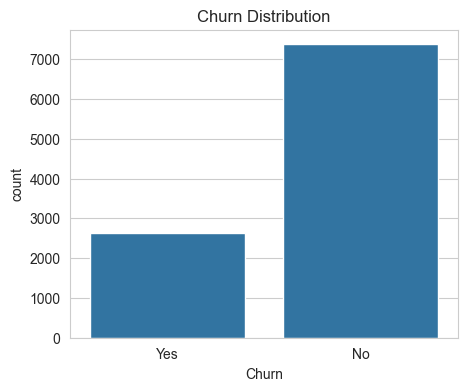

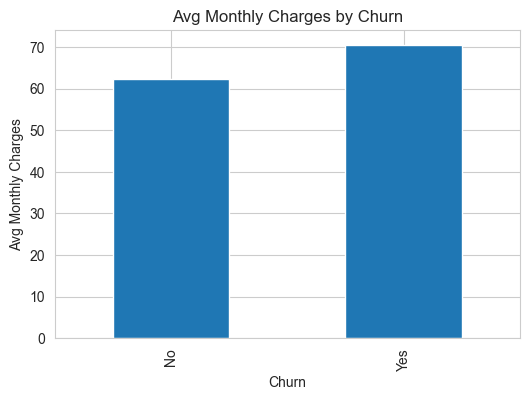

In [7]:

# Churn distribution
if 'Churn' in df.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(data=df, x='Churn')
    plt.title('Churn Distribution')
    plt.show()

# Avg MonthlyCharges by Churn (if present)
if 'MonthlyCharges' in df.columns and 'Churn' in df.columns:
    plt.figure(figsize=(6,4))
    df.groupby('Churn')['MonthlyCharges'].mean().plot(kind='bar')
    plt.title('Avg Monthly Charges by Churn')
    plt.ylabel('Avg Monthly Charges')
    plt.show()


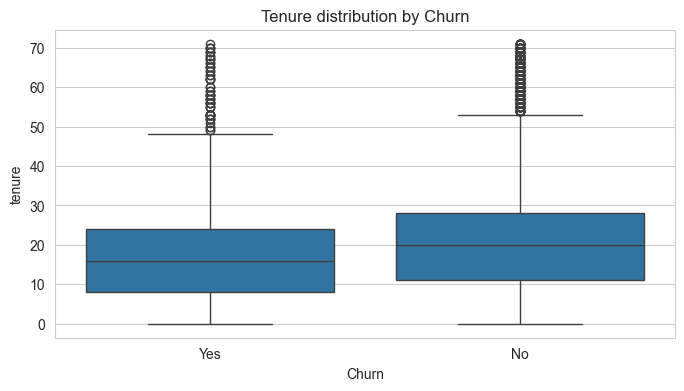

<Figure size 800x400 with 0 Axes>

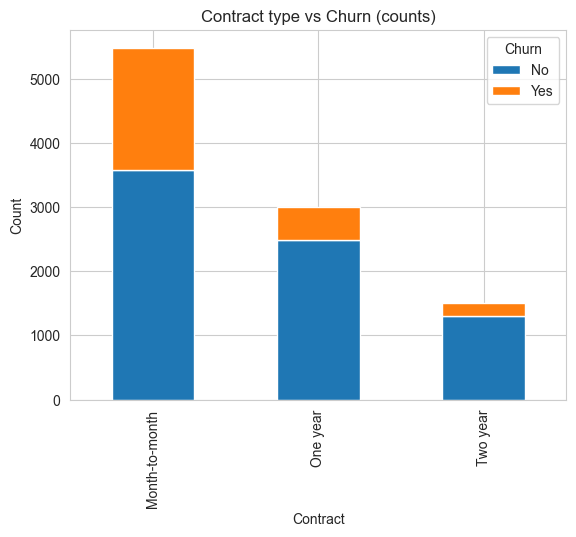

<Figure size 800x400 with 0 Axes>

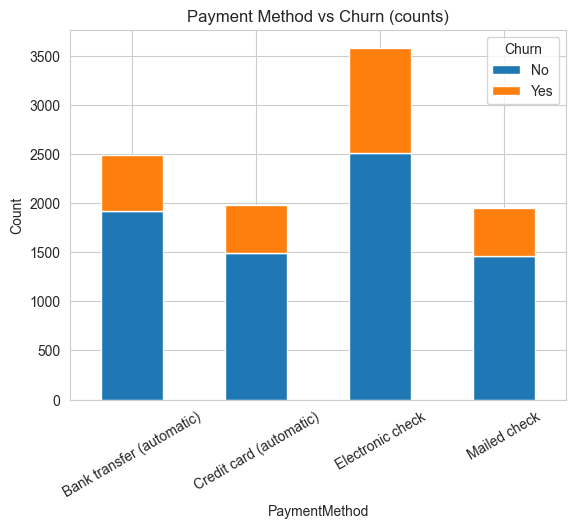

In [8]:

# Relationship between tenure, Contract and Churn
if set(['tenure','Contract','PaymentMethod','Churn']).issubset(df.columns):
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='Churn', y='tenure')
    plt.title('Tenure distribution by Churn')
    plt.show()

    plt.figure(figsize=(8,4))
    pd.crosstab(df['Contract'], df['Churn']).plot(kind='bar', stacked=True)
    plt.title('Contract type vs Churn (counts)')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(8,4))
    pd.crosstab(df['PaymentMethod'], df['Churn']).plot(kind='bar', stacked=True)
    plt.title('Payment Method vs Churn (counts)')
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    plt.show()
else:
    print('Optional columns for advanced EDA not present: tenure, Contract, PaymentMethod')


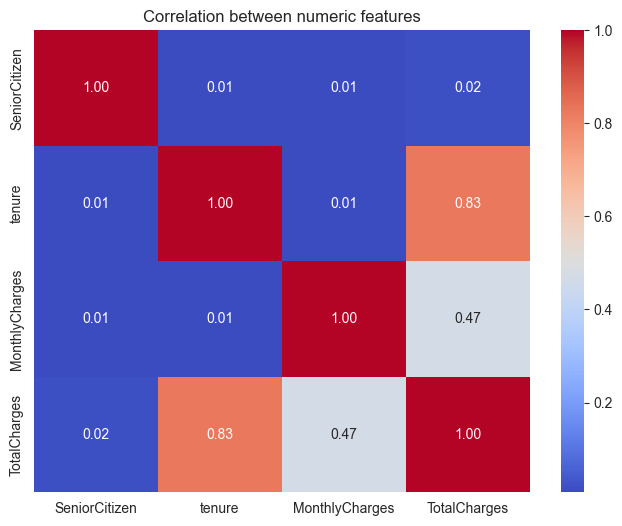

In [9]:

# Correlation heatmap (numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation between numeric features')
    plt.show()
else:
    print('Not enough numeric columns for correlation heatmap. Numeric columns:', num_cols)


In [10]:

# Preprocessing: simple label encoding for categorical features
data = df.copy()

if 'Churn' in data.columns:
    # Convert common yes/no to 1/0
    if data['Churn'].dtype == object:
        data['Churn'] = data['Churn'].map({'Yes':1, 'No':0}).astype('float')

# Select features automatically (numeric + a few categorical)
features = []
for col in data.columns:
    if col == 'Churn': continue
    if data[col].dtype in [np.number, 'int64', 'float64']:
        features.append(col)
    elif data[col].nunique() <= 10 and data[col].dtype == object:
        features.append(col)

print('Selected features for modeling:', features[:20])

# Encode categorical features with LabelEncoder (simple approach)
label_encoders = {}
for col in features:
    if data[col].dtype == object:
        le = LabelEncoder()
        data[col] = data[col].fillna('Missing')
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# Drop rows with missing target
data = data.dropna(subset=['Churn'])

X = data[features].fillna(0)
y = data['Churn'].astype(int)

print('\nX shape:', X.shape, 'y shape:', y.shape)


Selected features for modeling: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'InternetService', 'Contract', 'PaymentMethod', 'TechSupport', 'MonthlyCharges', 'TotalCharges']

X shape: (10000, 11) y shape: (10000,)


C:\Users\Acer\AppData\Local\Temp\ipykernel_7976\958136481.py:13: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[col].dtype in [np.number, 'int64', 'float64']:


In [11]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_lr))
print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, y_proba_lr))
print('\nClassification report (LR):\n', classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print('Random Forest accuracy:', accuracy_score(y_test, y_pred_rf))
print('Random Forest ROC-AUC:', roc_auc_score(y_test, y_proba_rf))
print('\nClassification report (RF):\n', classification_report(y_test, y_pred_rf))


Logistic Regression accuracy: 0.735
Logistic Regression ROC-AUC: 0.6573882163034706

Classification report (LR):
               precision    recall  f1-score   support

           0       0.74      0.99      0.85      1475
           1       0.39      0.02      0.03       525

    accuracy                           0.73      2000
   macro avg       0.57      0.50      0.44      2000
weighted avg       0.65      0.73      0.63      2000

Random Forest accuracy: 0.7005
Random Forest ROC-AUC: 0.5987893462469733

Classification report (RF):
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1475
           1       0.33      0.14      0.20       525

    accuracy                           0.70      2000
   macro avg       0.54      0.52      0.51      2000
weighted avg       0.64      0.70      0.65      2000



MonthlyCharges     0.281096
TotalCharges       0.272809
tenure             0.178025
PaymentMethod      0.062343
Contract           0.047607
Partner            0.031577
Gender             0.030923
Dependents         0.029251
InternetService    0.024800
TechSupport        0.020799
dtype: float64

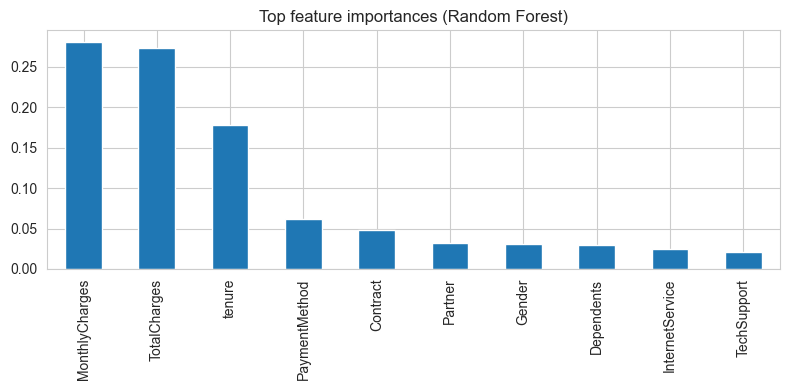

In [12]:

# Feature importance from Random Forest (if model trained)
if 'rf' in globals():
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances.head(10))
    plt.figure(figsize=(8,4))
    importances.head(10).plot(kind='bar')
    plt.title('Top feature importances (Random Forest)')
    plt.tight_layout()
    plt.show()


In [13]:

def run_quick_demo():
    print('Dataset shape:', df.shape)
    display(df.head())
    # Churn distribution
    if 'Churn' in df.columns:
        plt.figure(figsize=(5,4))
        sns.countplot(data=df, x='Churn')
        plt.title('Churn Distribution')
        plt.show()
    # MonthlyCharges by churn
    if 'MonthlyCharges' in df.columns and 'Churn' in df.columns:
        plt.figure(figsize=(6,4))
        df.groupby('Churn')['MonthlyCharges'].mean().plot(kind='bar')
        plt.title('Avg Monthly Charges by Churn')
        plt.ylabel('Avg Monthly Charges')
        plt.show()
    # Top features & model metrics if available
    if 'rf' in globals():
        print('\nTop features:')
        display(pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(5))
        print('\nModel accuracy (RF):', round(accuracy_score(y_test, y_pred_rf),3))
        print('ROC-AUC (RF):', round(roc_auc_score(y_test, y_proba_rf),3))
    else:
        print('\nModels not available. Run modeling cells to train.')

# Uncomment to run quick demo
# run_quick_demo()



---

## Business Recommendations (example)


- **Target high-risk customers:** customers with short tenure and month-to-month contracts show higher churn — offer loyalty discounts or early renewal incentives.
- **Payment flexibility:** customers using certain payment methods show higher churn — offer flexible payment plans.
- **Pricing & charges:** customers with high MonthlyCharges and low tenure are at risk — consider targeted offers.
- **Next steps:** build time-series retention campaigns, improve customer support quality metrics, and deploy a monitoring dashboard in Tableau for live KPIs.

---

**Notes:** If your original dataset uses different column names for tenure/contract/payment, update the column names used in EDA cells accordingly.
